In [1]:
## widen the cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
from typing import Union
import matplotlib.pyplot as plt
import seaborn as sns
from abc import ABC, abstractmethod
from collections import defaultdict
from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_auto

%matplotlib inline

In [3]:
def shermanMorrison(V:np.ndarray, x:np.ndarray):
    """
    ${V_t}^{-1} = V_{t-1}^{-1} - \frac{V_{t-1}^{-1}xx^T V_{t-1}^{-1}}{1 + x^T V_{t-1}^{-1} x}$
    V: inverse of old gram matrix, corresponding to $V_{t-1}$.
    x: a new observed context
    return: inverse of new gram matrix
    """
    numerator = np.einsum("ij, j, k, kl -> il", V, x, x, V)
    denominator = (1 + np.einsum("i, ij, j ->", x, V, x))
    return V - (numerator / denominator)


def l2norm(v:np.ndarray):
    v = v.flatten()
    return np.sqrt(np.sum(v ** 2))


def covariance_generator(d:int, distribution:str="gaussian", bound:float=None):
    if distribution == "gaussian":
        rnd = np.random.randn(d, d)
    elif distribution == "uniform":
        rnd = np.random.uniform(-1, 1, size=d*d).reshape(d, d)
    
    ## make a symmetric matrix
    sym = (rnd + rnd.T) / 2
    ## make positive semi-definite and bound its maximum singular value
    mat = sym @ sym.T
    
    if bound is not None:
        mat *= (bound / np.linalg.norm(mat, 2))
    
    return mat


# Function for Gram-Schmidt process
def gram_schmidt(A):
    Q = np.zeros(A.shape)
    for i in range(A.shape[1]):
        # Orthogonalize the vector
        Q[:,i] = A[:,i]
        for j in range(i):
            Q[:,i] -= np.dot(Q[:,j], A[:,i]) * Q[:,j]
        
        # Normalize the vector
        Q[:,i] = Q[:,i] / np.linalg.norm(Q[:,i])
    return Q


def make_diagonal(v:np.ndarray, dim:Union[int, tuple]):
    if type(dim) == int:
        diag = np.zeros((dim, dim))
        rng = dim
    else:
        diag = np.zeros(dim)
        rng = min(dim)
        
    for i in range(rng):
        diag[i, i] = v[i]
    
    return diag


def positive_definite_generator(dimension:int, distribution:str="uniform"):
    d = dimension
    ## create orthogonal eigenvectors
    source = np.random.uniform(-1, 1, size=(d*d)).reshape(d, d)
    eigvecs = gram_schmidt(source)
    
    ## create a matrix of eigenvalues
    eigvals = np.random.uniform(0, 1, size=d)
    eigmat = make_diagonal(np.absolute(eigvals))
    
    ## make the targeted positive definite matrix
    Z = source @ eigmat @ source.T
    return Z


def minmax(v:np.ndarray, bound:float=1.):
    min = np.min(v)
    max = np.max(v)
    return ((v - min) / (max - min)) * bound


def left_pseudo_inverse(A:np.ndarray):
    d, k = A.shape
    u, A_sig, v_T = np.linalg.svd(A)
    
    B_sig = np.zeros((k, d))
    for i in range(k):
        B_sig[i, i] = 1 / A_sig[i]
    
    B = v_T.T @ B_sig @ u.T
    
    return B


def rademacher(size:int):
    """
    Generate Rademacher random variables.

    Args:
    size (int): Number of random variables to generate.

    Returns:
    numpy.ndarray: An array of Rademacher random variables.
    """
    return 2 * np.random.randint(0, 2, size) - 1


def subgaussian_noise(distribution:str, size:int, random_state:int=None, std:float=None):
    """
    distribution (str): the distribution to sample a sub-Gaussian noise
    size (int): The number of total rounds (T)
    std (float): The variance proxy of the noise
    """
    if random_state is not None:
        np.random.seed(random_state)
        
    if distribution == "gaussian":
        if std is None:
            std = 1
        noise = np.random.normal(loc=0, scale=std, size=size) 
    elif distribution == "uniform":
        if std is None:
            low = -1
            high = 1
            std = np.sqrt(((high - low) ** 2) / 12)
        else:
            low = -np.sqrt(3) * std
            high = np.sqrt(3) * std
        noise = np.random.uniform(low=low, high=high, size=size)
    else:
        std = 1
        noise = rademacher(size=size)
    return noise, std

In [4]:
## Agent
class ContextualBandit(ABC):
    @abstractmethod
    def choose(self, x): pass
    
    @abstractmethod
    def update(self, x, r): pass

In [5]:
class LinUCB(ContextualBandit):
    def __init__(self, d, alpha, lbda=1.):
        self.alpha = alpha
        self.t = 0
        self.xty = np.zeros(d)
        self.Vinv = (1 / lbda) * np.identity(d)
        self.theta_hat = np.zeros(d)
        
    def choose(self, x):
        # x: action set at each round (N, d)
        self.t += 1
        
        ## compute the ridge estimator
        self.theta_hat = self.Vinv @ self.xty
        
        ## compute the ucb scores for each arm
        expected = x @ self.theta_hat # (N, ) theta_T @ x_t
        width = np.sqrt(np.einsum("Ni, ij, Nj -> N", x, self.Vinv, x) * np.log(self.t)) # (N, ) widths
        ucb_scores = expected + (self.alpha * width) # (N, ) ucb score
        
        ## chose the argmax the ucb score
        maximum = np.max(ucb_scores)
        argmax, = np.where(ucb_scores == maximum)
        
        return np.random.choice(argmax)
    
    def update(self, x, r):
        # x: context of the chosen action (d, )
        self.Vinv = shermanMorrison(self.Vinv, x)
        self.xty += (r * x)

In [6]:
## hyper-parameters
M = 40000         # number of samples
N = 20            # number of actions in the action set at each round
d = 10            # observable dimension
k = 10            # latent dimension
T = 25000         # total time horizon
SEED = 727        # random state

feature_bound = 1.
# matrix_lower_bound = 0.5  # lower bound of the decoder (inverse is the upper bound of the encoder)
matrix_bound = 1.
param_bound = 1.
reward_bound = 1.

ALPHAS = [0.0, 0.1, 0.3, 0.5, 1.0]
runtime = 4

In [7]:
## latent feature - gaussian, disjoint
# np.random.seed(SEED)
Z = np.random.multivariate_normal(mean=np.zeros(k), cov=np.identity(k), size=M)
print(f"Shape of the latent feature sets:\t{Z.shape}")
print(f"The first feature:\t{Z[0]}")

## bound the latent features
# # scaling
# maxnorm = np.max([l2norm(Z[i, :]) for i in range(M)])
# print(f"Maximum norm: {maxnorm:.5f}")
# Z *= (feature_bound / maxnorm)
# maxnorm = np.max([l2norm(Z[i, :]) for i in range(M)])
# print(f"Maximum norm: {maxnorm:.5f}")

# clipping
for i in range(M):
    latent = Z[i, :]
    if l2norm(latent) > feature_bound:
        Z[i, :] *= (feature_bound / l2norm(latent))
maxnorm = np.max([l2norm(Z[i, :]) for i in range(M)])
print(f"Maximum norm: {maxnorm:.5f}")

Shape of the latent feature sets:	(40000, 10)
The first feature:	[ 0.8281627   0.1896365   0.05466672  0.92581008 -0.51171115 -1.72240679
 -0.37237365  0.56395344  0.20145704 -0.9413047 ]
Maximum norm: 1.00000


In [8]:
## mapping - uniform distribution
# np.random.seed(SEED)
A = np.random.uniform(low=-np.sqrt(2/k), high=np.sqrt(2/k), size=d*k).reshape(d, k)
print(f"Shape of the mapping: {A.shape}")
print(f"Mapping: {A}")

## bound the mapping
spectral_norm = np.linalg.norm(A, 2)
print(f"Maximum singular value: {spectral_norm:.5f}")
A *= (matrix_bound / spectral_norm)
print(f"Singular values of A: {np.linalg.svd(A)[1]}")

Shape of the mapping: (10, 10)
Mapping: [[ 0.14002394 -0.140616    0.16554728 -0.36065593 -0.20536469  0.28139284
  -0.12419171 -0.29925413 -0.20617443  0.26556385]
 [ 0.25779846 -0.07462274  0.23634237  0.41502274 -0.23271757  0.23557332
   0.34505331  0.03908676  0.2502462   0.10274371]
 [ 0.0857129   0.04143006  0.41082583  0.13081939  0.34457669  0.42878564
  -0.09827938  0.13068836 -0.10082504 -0.37435713]
 [ 0.17599582  0.35375324 -0.06423214 -0.3604875  -0.23699372  0.07205574
   0.22750463  0.10002085 -0.36215463  0.25302598]
 [-0.2350513  -0.15729035 -0.16315382  0.04714501  0.33301964  0.3861818
  -0.11681836 -0.0176791   0.40772575 -0.21629685]
 [ 0.44537937 -0.23779561  0.30691373  0.03572091  0.11124688  0.44333367
   0.04949985  0.3842115   0.40016453  0.14511699]
 [-0.00230521 -0.37989984  0.32876926 -0.15613054  0.1105624  -0.2955263
   0.13123308  0.11480334 -0.24982135  0.34260683]
 [ 0.35570081 -0.38554163 -0.40953217 -0.20825916 -0.3913157  -0.33199682
  -0.01990547

In [9]:
## observable feature X
# making by row-by-row
X_src = [A@Z[i] for i in range(M)]
X_ = np.array(X_src)
print(f"X_.shape: {X_.shape}")
print(f"First observable context: {X_[0, :]}")
maxnorm = np.max([l2norm(X_[i, :]) for i in range(M)])
print(f"Maximum norm: {maxnorm:.5f}")

X_.shape: (40000, 10)
First observable context: [-0.29320062  0.04475241 -0.07124621 -0.13295739 -0.20115044 -0.08679618
 -0.02992366  0.20257877  0.02395078  0.08210083]
Maximum norm: 0.95700


In [10]:
# making as a whole
X = Z @ A.T
print(f"X.shape: {X.shape}")
print(f"First observable context: {X[0, :]}")
maxnorm = np.max([l2norm(X[i, :]) for i in range(M)])
print(f"Maximum norm: {maxnorm:.5f}")

X.shape: (40000, 10)
First observable context: [-0.29320062  0.04475241 -0.07124621 -0.13295739 -0.20115044 -0.08679618
 -0.02992366  0.20257877  0.02395078  0.08210083]
Maximum norm: 0.95700


In [11]:
## sample the context noise - i.i.d, each element is sub-gaussian
noise_std = 1/(T**0.5)
context_noise, std = subgaussian_noise(distribution="gaussian", size=(M*d), std=noise_std)
context_noise = context_noise.reshape(M, d)
print(f"Shape: {context_noise.shape}\tStandard deviation: {std}")
print(f"First context noise: {context_noise[0]}")

Shape: (40000, 10)	Standard deviation: 0.006324555320336758
First context noise: [-0.006664    0.00479568 -0.0039923  -0.00234785 -0.00018117  0.00154677
  0.00056144  0.00838627  0.00289623  0.00056651]


In [12]:
## Add the context noise to the observable one
X = X + context_noise
maxnorm = np.max([l2norm(X[i, :]) for i in range(M)])
print(f"Before scaling\t- Maximum norm: {maxnorm:.5f}")

## scaling
X *= (feature_bound / maxnorm)
maxnorm = np.max([l2norm(X[i, :]) for i in range(M)])
print(f"After scaling\t- Maximum norm: {maxnorm:.5f}")

Before scaling	- Maximum norm: 0.96308
After scaling	- Maximum norm: 1.00000


In [13]:
print(f"First latent feature: {Z[0]}")
print(f"First observable feature: {X[0]}")
print(f"Distance between the latent and observable: {l2norm(Z[0]-X[0])}")

First latent feature: [ 0.33276439  0.07619792  0.02196566  0.37200012 -0.20561086 -0.69208096
 -0.1496236   0.22660236  0.08094753 -0.37822602]
First observable feature: [-0.31136052  0.05144761 -0.07812293 -0.14049243 -0.20905005 -0.08851762
 -0.03048788  0.21905281  0.02787624  0.08583655]
Distance between the latent and observable: 1.1335331076412145


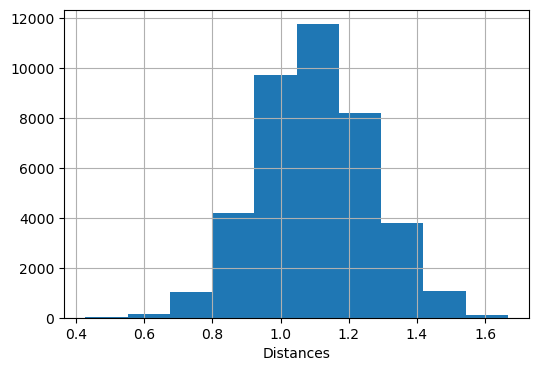

In [14]:
## histogram of the distance between the latent and observable
distances = np.zeros(M)
for i in range(M):
    diff = Z[i, :] - X[i, :]
    distances[i] = l2norm(diff)
    
plt.figure(figsize=(6, 4))
plt.hist(distances)
plt.grid(True)
plt.xlabel("Distances")
plt.show()

In [15]:
## reward parameter
true_theta = np.random.uniform(low=-1., high=1., size=k)
if l2norm(true_theta) > 1:
    true_theta *= (1 / l2norm(true_theta))
print(f"True reward parameter: {true_theta}")
print(f"L2-norm of the true theta: {l2norm(true_theta):.5f}")

True reward parameter: [ 0.48321477  0.3522328  -0.06578007 -0.39096125 -0.21392353 -0.11392118
 -0.27750055  0.36111511  0.14272009  0.44579908]
L2-norm of the true theta: 1.00000


In [16]:
reward_noise_std = 0.1
result = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    agent = LinUCB(d=d, alpha=alpha)
    regrets = np.zeros(T)
    theta_distances = np.zeros(T)
    played_optimal = np.zeros(T)
    for t in tqdm_auto(range(T)):
#         np.random.seed(int(SEED+t+(100*alpha)))
        ## sample the action space
        idx = np.random.choice(np.arange(M), size=N, replace=False)
#         action_set, latent_set = X[idx, :], Z[idx, :]
        latent_set = Z[idx, :]
        context_noise, std = subgaussian_noise(distribution="gaussian", size=(N*d), std=noise_std)
        context_noise = context_noise.reshape(N, d)
        action_set = latent_set @ A.T + context_noise
        
        # scaling
        for i in range(N):
            action = action_set[i]
            if l2norm(action) > feature_bound:
                action_set[i] *= (feature_bound / l2norm(action))
#         maxnorm = np.max([l2norm(action) for action in action_set])
#         action_set *= (feature_bound / maxnorm)

        ## sample the reward noise and compute the optimal arm
        reward_noise, std = subgaussian_noise(distribution="gaussian", std=reward_noise_std, size=N)
        expected_reward = latent_set @ true_theta
        if t == 0:
            print(f"E[r_t] range: [{np.min(expected_reward)}, {np.max(expected_reward)}]")
        true_reward = expected_reward + reward_noise
        optimal_arm = np.argmax(expected_reward)
        optimal_reward = expected_reward[optimal_arm]

        ## choose the best action and compute the instance regret
        chosen_arm = agent.choose(action_set)
        chosen_context = action_set[chosen_arm]
        chosen_reward = true_reward[chosen_arm]
        regret_t = optimal_reward - expected_reward[chosen_arm]
        regrets[t] = regret_t
        theta_distances[t] = l2norm(true_theta - agent.theta_hat)
        played_optimal[t] = (chosen_arm == optimal_arm)
        
#         print(f"Round:{t} \tOptimal arm:{optimal_arm}\tChosen arm:{chosen_arm}\tregret_t:{regret_t:.5f}\tRegret_t:{np.cumsum(regrets)[t]:.5f}\tTheta distance:{theta_distances[t]:.5f}\tPlayed optimal:{played_optimal[t]}")
        
        ## update the agent
        agent.update(x=chosen_context, r=chosen_reward)
        
    result[alpha] = (np.cumsum(regrets), theta_distances, (np.cumsum(played_optimal)/(np.arange(T)+1)))

alpha=0.0


  0%|          | 0/25000 [00:00<?, ?it/s]

E[r_t] range: [-0.5498838908805961, 0.7351230483579255]
alpha=0.1


  0%|          | 0/25000 [00:00<?, ?it/s]

E[r_t] range: [-0.6659842599230367, 0.4692979967449341]
alpha=0.3


  0%|          | 0/25000 [00:00<?, ?it/s]

E[r_t] range: [-0.5296190729029572, 0.5061364184291395]
alpha=0.5


  0%|          | 0/25000 [00:00<?, ?it/s]

E[r_t] range: [-0.47274757701051223, 0.5872069899650965]
alpha=1.0


  0%|          | 0/25000 [00:00<?, ?it/s]

E[r_t] range: [-0.2133067487187298, 0.5624712922811587]


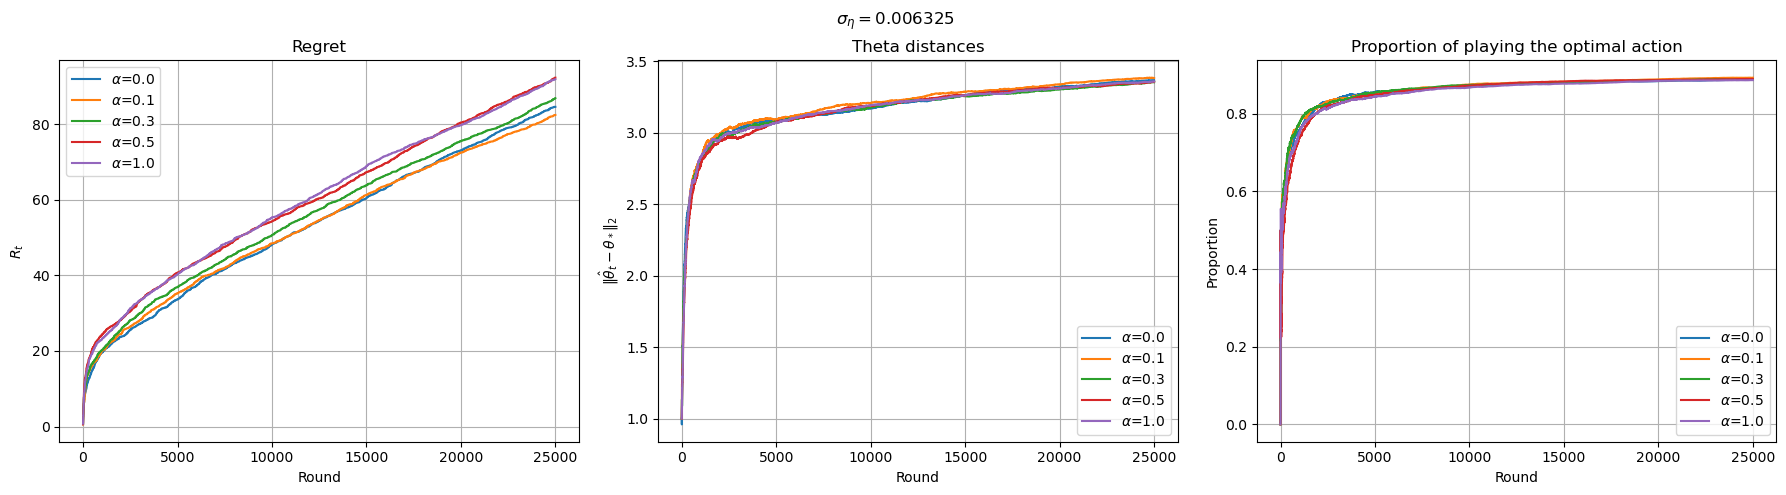

In [17]:
plt.figure(figsize=(18, 5))
alpha_label = r"$\alpha$"
for key, value in result.items():
    regret, distance, played_optimal = value
    
    plt.subplot(131)
    plt.plot(regret, label=f"{alpha_label}={key}")
    plt.grid(True)
    plt.xlabel("Round")
    plt.ylabel(r"$R_t$")
    plt.legend()
    plt.title("Regret")
    
    plt.subplot(132)
    plt.plot(distance, label=f"{alpha_label}={key}")
    plt.grid(True)
    plt.xlabel("Round")
    plt.ylabel(r"${\Vert \hat{\theta}_t - \theta_* \Vert}_2$")
    plt.legend()
    plt.title("Theta distances")
    
    plt.subplot(133)
    plt.plot(played_optimal, label=f"{alpha_label}={key}")
    plt.grid(True)
    plt.xlabel("Round")
    plt.ylabel("Proportion")
    plt.legend()
    plt.title("Proportion of playing the optimal action")

plt.tight_layout(rect=[0, 0, 1, 0.95])
title_label = r"$\sigma_\eta=$"
plt.suptitle(f"{title_label}{noise_std:.6f}")
plt.show()

In [22]:
for i in range(10000):
    cov = covariance_generator(d=10, distribution="gaussian")
    if not (np.diag(cov) >= 0).all():
        print(i)

In [29]:
def generate_uniform(dim:Union[int, tuple], uniform_rng:list=None):
    assert type(dim) == int or type(dim) == tuple, "The type of 'dim' must be either int or tuple."
    
    if uniform_rng is None:
        low, high = -1., 1.
    else:
        assert len(uniform_rng) == 2, "The 'uniform_rng' must contain two elements: low and high."
        low, high = uniform_rng
        
    if type(dim) == int:
        size = dim
    else:
        dim1, dim2 = dim
        size = dim1 * dim2    
    return np.random.uniform(low=low, high=high, size=size).reshape(dim)


def covariance_generator(d:int, independent:bool, distribution:str=None, uniform_rng:list=None, 
                         variances:Union[list, np.ndarray]=None):
    if independent:
        if variances is None:
            assert distribution is not None and distribution.lower() in ["gaussian", "uniform"], "If the variances are not given, you need to pass the distribution to sample them."
            ## then variances are sampled randomly
            if distribution == "gaussian":
                variances = (np.random.randn(d)) ** 2
            else:
                variances = (generate_uniform(dim=d, uniform_rng=uniform_rng)) ** 2

        mat = np.zeros(shape=(d, d))
        for i in range(d):
            mat[i, i] = variances[i]
    
    else:
        assert distribution is not None and distribution.lower() in ["gaussian", "uniform"], f"If independent is {independent}, you need to pass the distribution to sample them."
        if distribution == "gaussian":
            rnd = np.random.randn(d, d)
        elif distribution == "uniform":
            rnd = generate_uniform(dim=(d, d), uniform_rng=uniform_rng)
        
        ## make a symmetric matrix
        sym = (rnd + rnd.T) / 2
        ## make positive semi-definite and bound its maximum singular value
        mat = sym @ sym.T
        if variances is not None:
            for i in range(d):
                mat[i, i] = variances[i]

    return mat

In [30]:
covariance_generator(d=5, independent=False, distribution="uniform")

array([[ 0.55736965, -0.13723098, -0.05507049,  0.17308232, -0.32781566],
       [-0.13723098,  0.76316639,  0.04785917,  0.17546678, -0.09530399],
       [-0.05507049,  0.04785917,  0.352694  , -0.178825  ,  0.04007331],
       [ 0.17308232,  0.17546678, -0.178825  ,  0.88922041,  0.14835599],
       [-0.32781566, -0.09530399,  0.04007331,  0.14835599,  0.63941521]])